# Differential TF activity

In [17]:
import gzip
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Load matched set of data

Using top 10 % of DNase peaks from both HepG2 and K562
Both should be using exactly the same set of positions.

In [3]:
deep_k562 = {} # chrom -> position -> score
files = ['/mnt/dnase/hepg2_deeplift_1_20000.tsv.gz',
         '/mnt/dnase/hepg2_deeplift_1_40000.tsv.gz',
         '/mnt/dnase/k562_deeplift_1_20000.tsv.gz',
         '/mnt/dnase/k562_deeplift_1_40000.tsv.gz',
        ]
for fn in files:
    with gzip.open(fn) as fp:
        for line in fp:
            chrom, pos, score = line.strip().split()
            if chrom not in deep_k562:
                deep_k562[chrom] = {}
            deep_k562[chrom][int(pos)] = float(score)

In [6]:
deep_hepg2 = {} # chrom -> position -> score
files = ['/mnt/dnase/hepg2_deeplift_20000.tsv.gz',
         '/mnt/dnase/hepg2_deeplift_40000.tsv.gz',
         '/mnt/dnase/k562_deeplift_20000.tsv.gz',
         '/mnt/dnase/k562_deeplift_40000.tsv.gz',
        ]
for fn in files:
    with gzip.open(fn) as fp:
        for line in fp:
            chrom, pos, score = line.strip().split()
            if chrom not in deep_hepg2:
                deep_hepg2[chrom] = {}
            deep_hepg2[chrom][int(pos)] = float(score)

# Load set of ENCODE TFBS

Just keep the relavent ones, so we don't run out of RAM...

In [7]:
encode = {}
with gzip.open('/mnt/matches.txt.gz') as regions:
    for i, line in enumerate(regions):
        motif, chrom, start, end, strand = line.strip().split()
        start, end = int(start), int(end)
        if chrom not in encode: encode[chrom] = {}
        if chrom not in deep_hepg2: continue
        if start not in deep_hepg2[chrom]: continue
        for pos in range(start, end):
            if pos not in encode[chrom]: encode[chrom][pos] = set()
            encode[chrom][pos].add(motif)

# Create lists of activities for each TF

The resulting lists are matched exactly, so later our
T-test for differential activity will be fair.

In [8]:
k562_encode = {}
hepg2_encode = {}

for chrom, positions in deep_hepg2.items():
    if chrom == 'chrY': continue
    for pos, score in positions.items():
        if pos in encode[chrom]:
            for motif in encode[chrom][pos]:
                if not motif in k562_encode:
                    k562_encode[motif] = []
                    hepg2_encode[motif] = []
                k562_encode[motif]  += [deep_k562[chrom][pos]]
                hepg2_encode[motif] += [score]

-0.00082943971092 0.00050933741525 ZBTB33_known1
-0.000186227494457 -0.000673755090965 ZBTB33_disc4
0.109174534623 0.104925179949 ZBTB33_disc1
0.00428754952673 0.00515814472821 ZBTB33_disc3
0.00671071216251 0.0115615502661 ZBTB33_disc2
SpearmanrResult(correlation=0.75724042210638776, pvalue=0.0)
LinregressResult(slope=0.98068117153622381, intercept=0.00016352210003696237, rvalue=0.96956481176933806, pvalue=0.0, stderr=0.0056340482909404419)


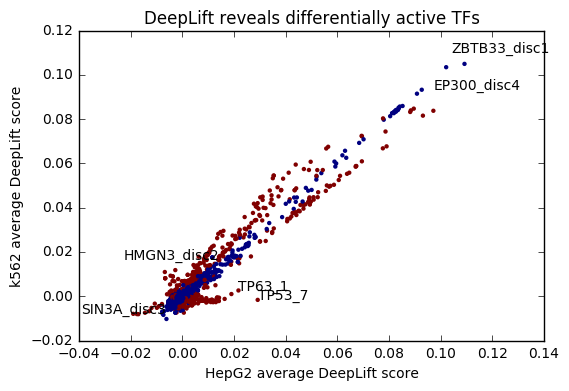

In [81]:
hepG2, k562, names, p = [], [], [], []

for motif, k in k562_encode.items():
    h = hepg2_encode[motif]
    hepG2 += [sum(h) / float(len(h))]
    k562  += [sum(k) / float(len(k))]
    names += [motif]#.split('_')[0]]
    p += [stats.ttest_rel(h, k)[1]]
    if motif.split('_')[0] == 'ZBTB33': print hepG2[-1], k562[-1], motif
    
fig, ax = plt.subplots()
cs = ax.scatter(hepG2, k562, c = np.array(p) < float('1e-5') / float(len(hepG2)), s = 10, lw = 0)

for i, txt in enumerate(names):
    if hepG2[i] > .02 and k562[i] < 0.01:
        shift = 0
        if txt == 'TP53': shift = -.007
        ax.annotate(txt, (hepG2[i], k562[i] + shift))
    if hepG2[i] > .1 and k562[i] > 0.1:
        shift = 0.005
        if txt[:2] == 'EP': shift = -.01
        ax.annotate(txt, (hepG2[i] - .005, k562[i] + shift))  
    if hepG2[i] <  - .019 and k562[i] <  0:
        ax.annotate(txt, (hepG2[i] - .02, k562[i]))
        
    if hepG2[i] < 0 and k562[i] >  .011:
        ax.annotate(txt, (hepG2[i] - .02, k562[i] + .005))

print stats.spearmanr(hepG2, k562)
print stats.linregress(hepG2, k562)
plt.title('DeepLift reveals differentially active TFs')
plt.xlabel('HepG2 average DeepLift score')
plt.ylabel('k562 average DeepLift score')
plt.ylim(-.02, 0.12)
plt.show()

SpearmanrResult(correlation=0.80748355227197333, pvalue=1.1690247597836075e-139)
LinregressResult(slope=0.98667663240635128, intercept=-8.9417867706403746e-05, rvalue=0.98015546717062629, pvalue=0.0, stderr=0.0081465614034231144)


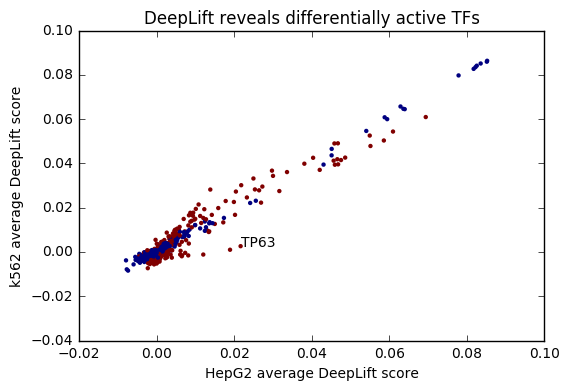

In [69]:
hepG2, k562, names, p = [], [], [], []
merged_hepg2, merged_k562 = {}, {}

for motif, k in k562_encode.items():
    h = hepg2_encode[motif]
    name = motif.split('_')[0]
    if name not in merged_hepg2:
        merged_hepg2[name] = []
        merged_k562[name] = []
    merged_hepg2[name] += h
    merged_k562[name] += k

for motif, k in merged_k562.items():
    h = merged_hepg2[motif]
    hepG2 += [sum(h) / float(len(h))]
    k562  += [sum(k) / float(len(k))]
    names += [motif.split('_')[0]]
    p += [stats.ttest_rel(h, k)[1]]
    
fig, ax = plt.subplots()
cs = ax.scatter(hepG2, k562, c = np.array(p) < float('1e-5') / float(len(hepG2)), s = 10, lw = 0)

for i, txt in enumerate(names):
    if hepG2[i] > .02 and k562[i] < 0.01:
        shift = 0
        if txt == 'TP53': shift = -.005
        ax.annotate(txt, (hepG2[i], k562[i] + shift))
    if hepG2[i] > .1 and k562[i] > 0.1:
        shift = 0
        if txt[:2] == 'EP': shift = -.01
        ax.annotate(txt, (hepG2[i], k562[i] + shift))  
    if hepG2[i] <  - .019 and k562[i] <  0:
        ax.annotate(txt, (hepG2[i] - .017, k562[i]))
        
    if hepG2[i] < 0 and k562[i] >  .011:
        ax.annotate(txt, (hepG2[i] - .02, k562[i] + .005))

print stats.spearmanr(hepG2, k562)
print stats.linregress(hepG2, k562)
plt.title('DeepLift reveals differentially active TFs')
plt.xlabel('HepG2 average DeepLift score')
plt.ylabel('k562 average DeepLift score')
plt.show()

In [88]:
#activity = np.zeros((60,))
with gzip.open('/mnt/matches.txt.gz') as regions:
    for i, line in enumerate(regions):
        motif, chrom, start, end, strand = line.strip().split()
        print end, start
        break
        if motif != 'ZBTB33_disc1': continue
        start, end = int(start), int(end)
        if chrom not in deep_hepg2: continue
        if start-20 not in deep_hepg2[chrom]: continue
        if end+20 not in deep_hepg2[chrom]: continue
        for i, pos in enumerate(range(start-20, end+20)):
            activity[i] += deep_hepg2[chrom][pos] if pos in deep_hepg2[chrom] else 0
            

11493 11482


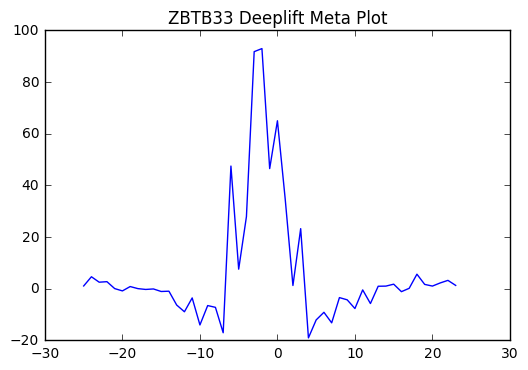

In [90]:
plt.plot(range(-49/ 2, 49 / 2), activity[:49])
plt.title("ZBTB33 Deeplift Meta Plot")
plt.show()